# Earthdata Cloud Access and PACE Demo

Based on the PACE Hackweek Tutorial started by Anna Windle and Continued by Patrick Gray

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov/

## 1. Setup

We begin by importing the packages used in this notebook.

This will also install a few packages in case you're working in colab.

In [2]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import LogNorm
import cmocean
import pandas as pd
import matplotlib.colors as mcolors
import os

The last import provides a preview of the `DataTree` object. Once it is fully integrated into XArray,
the additional import won't be needed, as the function will be available as `xr.open_datree`.

[back to top](#Contents)

In [3]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

Notice that this `xarray.Dataset` has nothing but "Attributes". The NetCDF data model includes multi-group hierarchies within a single file, where each group maps to an `xarray.Dataset`. The whole file maps to a `DataTree`, which we will only use lightly because the implementation in XArray remains under development.

Let's set the coordinates and plot with latitude and longitude so we can project the data onto a grid.

And if we want to get fancy, we can add the coastline.

But really chla is typically lognormally distributed to let's use a log normal scale

But some of this data may be suspicious so let's check out the flags. They're available in the data here:

And you can inspect all the current flags on https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/ and they're listed below and put into a python dictionary.

[back to top](#Contents)

## 5. Open L3M Data

Let's use `earthaccess` to open some L3 mapped chlorophyll a granules. We will use a new search filter available in earthaccess.search_data: the granule_name argument accepts strings with the "*" wildcard. We need this to distinguish daily ("DAY") from eight-day ("8D") composites, as well as to get the 0.1 degree resolution projections.

In [4]:
tspan = ("2015-01-30", "2016-12-30")

results = earthaccess.search_data(
    short_name="OMPS_NPP_LP_L3_AER_MONTHLY",
    temporal=tspan,
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

Let's open the first file using `xarray`.

In [12]:
dataset = xr.open_dataset(paths[4])
dataset

<xarray.Dataset> Size: 6MB
Dimensions:             (Altitude: 41, Longitude: 24, Latitude: 36,
                         Wavelength: 6)
Coordinates:
  * Altitude            (Altitude) float32 164B 0.5 1.5 2.5 ... 38.5 39.5 40.5
  * Latitude            (Latitude) float32 144B -87.5 -82.5 -77.5 ... 82.5 87.5
  * Longitude           (Longitude) float32 96B -172.5 -157.5 ... 157.5 172.5
  * Wavelength          (Wavelength) float32 24B 510.0 600.0 ... 869.0 997.0
Data variables: (12/14)
    ExtRatioAvg         (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ExtRatioStDev       (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ExtRatioStErr       (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ExtinctionAvg       (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ExtinctionStDev     (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ExtinctionStErr     (Longitude, Latitude, Altitude, Wavelength) float32 850kB ...
    ...                  ...
    NumSamples          (Longitude, Latitude, Wavelength) float32 21kB ...
    Pressure            (Longitude, Latitude, Altitude) float32 142kB ...
    ScatteringAngle     (Longitude, Latitude) float32 3kB ...
    StratColumn         (Longitude, Latitude, Wavelength) float32 21kB ...
    Temperature         (Longitude, Latitude, Altitude) float32 142kB ...
    TropopauseAltitude  (Longitude, Latitude) float32 3kB ...
Attributes: (12/65)
    APPName:                         LP-L3-AER-MONTHLY
    APPVersion:                      1.0.8
    ArchiveSetName:                  OMPS NPP v2.5 Processing Stream 2
    ArchiveSetNumber:                61006
    Conventions:                     ACDD-1.3
    DOI:                             10.5067/BXR8K06YPR6U
    ...                              ...
    references:                      Taha, G., Loughman, R., Zhu, T., Thomaso...
    source:                          Suomi-NPP OMPS Limb Profiler
    summary:                         OMPS-NPP LP L3 Gridded Aerosol Monthly V1.0
    time_coverage_end:               2015-06-01T00:00:00Z
    time_coverage_start:             2015-05-01T00:00:00Z
    title:                           Suomi-NPP OMPS Limb Profiler Gridded Aer...

In [77]:
print("Dataset dimensions:", list(dataset.dims))
print("Dataset coordinates:", list(dataset.coords))
print("Dataset variables:", list(dataset.data_vars))

Dataset dimensions: ['Altitude', 'Longitude', 'Latitude', 'Wavelength']
Dataset coordinates: ['Altitude', 'Latitude', 'Longitude', 'Wavelength']
Dataset variables: ['ExtRatioAvg', 'ExtRatioStDev', 'ExtRatioStErr', 'ExtinctionAvg', 'ExtinctionStDev', 'ExtinctionStErr', 'NumDensAvg', 'NumGoodScreen', 'NumSamples', 'Pressure', 'ScatteringAngle', 'StratColumn', 'Temperature', 'TropopauseAltitude']


In [87]:
strat_column_vars = [var for var in dataset.data_vars if 'strat' in var.lower()]
print("Potential stratospheric column variables:", strat_column_vars)

Potential stratospheric column variables: ['StratColumn']


In [13]:
strat_var = "StratColumn"

Becuase the L3M variables have lat and lon coordinates, it's possible to stack multiple granules along a new dimension that corresponds to time. Instead of xr.open_dataset, we use xr.open_mfdataset to create a single xarray.Dataset (the "mf" in open_mfdataset stands for multiple files) from an array of paths.

The paths list is sorted temporally by default, which means the shape of the paths array specifies the way we need to tile the files together into larger arrays. We specify combine="nested" to combine the files according to the shape of the array of files (or file-like objects), even though paths is not a "nested" list in this case. The concat_dim="date" argument generates a new dimension in the combined dataset, because "date" is not an existing dimension in the individual files.

A common reason to generate a single dataset from multiple, daily images is to create a composite. Compare the map from a single day ...

In [138]:
# Compare longitude ranges between months
march_dataset = xr.open_dataset(paths[2])  # March
april_dataset = xr.open_dataset(paths[3])  # April

print("March longitude range:")
print(f"  Min: {march_dataset['Longitude'].min().values:.1f}°")
print(f"  Max: {march_dataset['Longitude'].max().values:.1f}°")
print(f"  Coverage: {march_dataset['Longitude'].max().values - march_dataset['Longitude'].min().values:.1f}°")

print("\nApril longitude range:")
print(f"  Min: {april_dataset['Longitude'].min().values:.1f}°")  
print(f"  Max: {april_dataset['Longitude'].max().values:.1f}°")
print(f"  Coverage: {april_dataset['Longitude'].max().values - april_dataset['Longitude'].min().values:.1f}°")

March longitude range:
  Min: -172.5°
  Max: 172.5°
  Coverage: 345.0°

April longitude range:
  Min: -172.5°
  Max: 172.5°
  Coverage: 345.0°


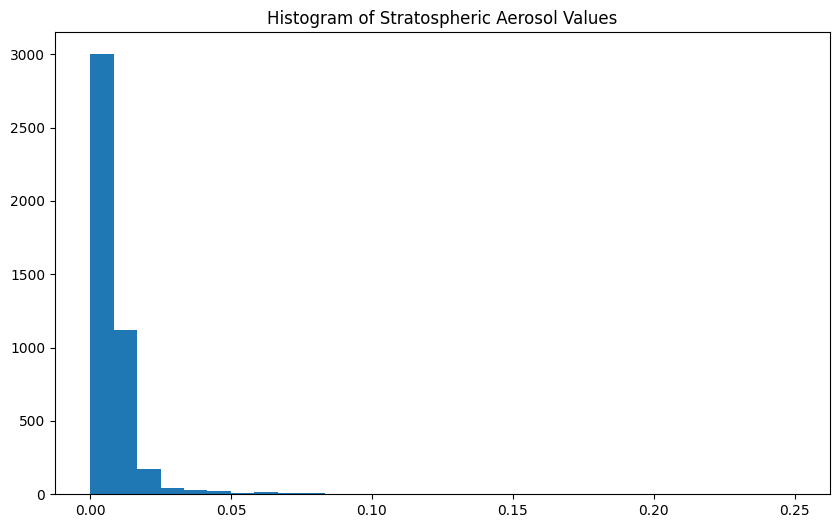

In [62]:
plt.figure(figsize=(10, 6))
plt.hist(dataset[strat_var].values.flatten(), range=[0, 0.25], bins=30)
plt.title("Histogram of Stratospheric Aerosol Values")
plt.show()

In [7]:
save_directory = "Plots/Spatial Stratospheric Aerosols"
os.makedirs(save_directory, exist_ok=True)

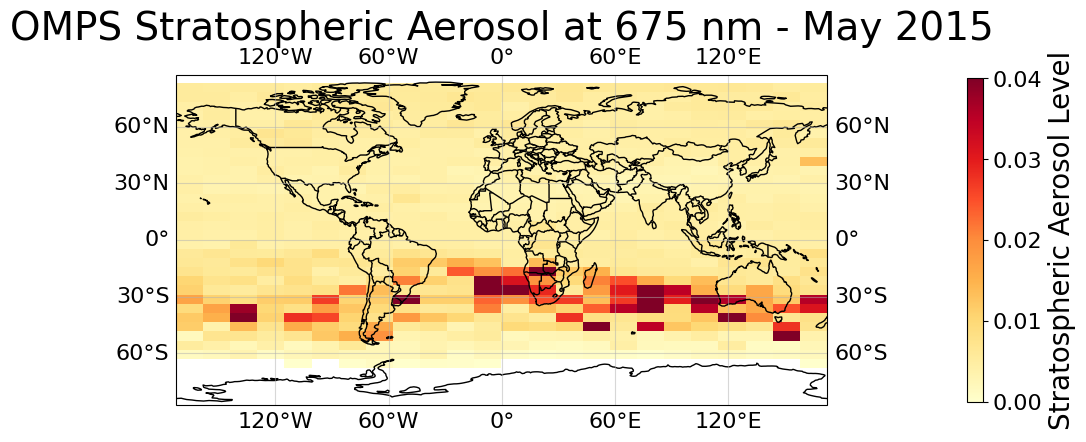

In [14]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

data = dataset[strat_var]

if 'Wavelength' in data.dims:
    wavelengths = dataset.Wavelength.values
    target_wavelength = 675
    closest_idx = np.argmin(np.abs(wavelengths - target_wavelength))
    actual_wavelength = wavelengths[closest_idx]
    
    data = data.isel(Wavelength=closest_idx)
    wavelength_label = f" at {actual_wavelength} nm"
else:
    wavelength_label = ""

lat = dataset['Latitude'].values
lon = dataset['Longitude'].values

colors = ['yellow', 'orange', 'red', 'darkred']
n_bins = 256
cmap_custom = mcolors.LinearSegmentedColormap.from_list('yellow_red', colors, N=n_bins)

im = ax.imshow(data.values.T, 
               extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               transform=ccrs.PlateCarree(),
               cmap='YlOrRd',
               vmin=0, vmax=0.04, 
               origin='lower')

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabel_style = {'size': 16}  # Longitude label size
gl.ylabel_style = {'size': 16}
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.15)
cbar.set_label(f'Stratospheric Aerosol Level', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.title(f"OMPS Stratospheric Aerosol at 675 nm - May 2015", fontsize=28)

save_path = os.path.join(save_directory, 'May2015_SpatialAerosols.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

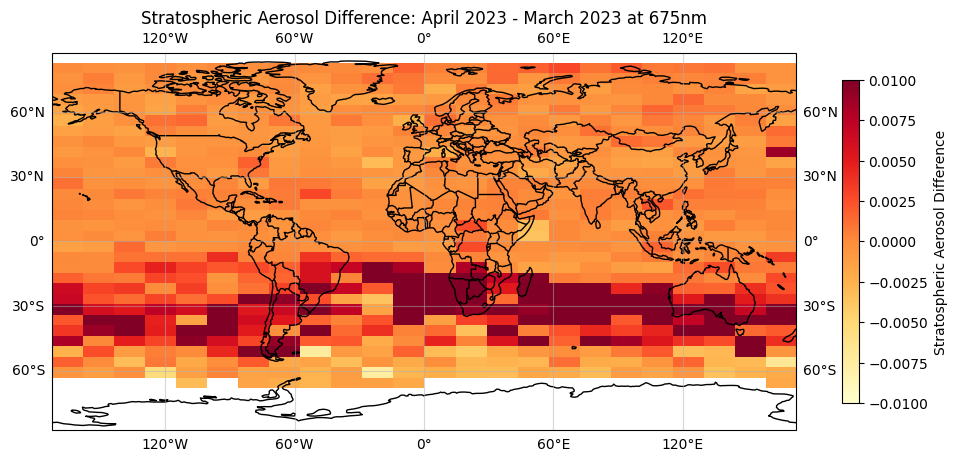

In [32]:
march_dataset = xr.open_dataset(paths[3]) 
april_dataset = xr.open_dataset(paths[4])  

march_data = march_dataset["StratColumn"]
april_data = april_dataset["StratColumn"]

if 'Wavelength' in march_data.dims:
    wavelengths = march_dataset.Wavelength.values
    target_wavelength = 675
    closest_idx = np.argmin(np.abs(wavelengths - target_wavelength))
    
    march_data = march_data.isel(Wavelength=closest_idx)
    april_data = april_data.isel(Wavelength=closest_idx)

difference = april_data - march_data

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

lat = march_dataset['Latitude'].values
lon = march_dataset['Longitude'].values

# Plot the difference using a diverging colormap (good for showing positive/negative changes)
im = ax.imshow(difference.values.T, 
               extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               transform=ccrs.PlateCarree(),
               cmap='YlOrRd',  # Red-Blue colormap (red=positive, blue=negative)
               vmin=-0.01, vmax=0.01,  # Adjust range based on your difference values
               origin='lower')

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True, alpha=0.5)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.05)
cbar.set_label('Stratospheric Aerosol Difference')

plt.title('Stratospheric Aerosol Difference: April 2023 - March 2023 at 675nm')
plt.show()


In [169]:
difference

<xarray.DataArray 'StratColumn' (Longitude: 24, Latitude: 36, Wavelength: 6)> Size: 21kB
dask.array<truediv, shape=(24, 36, 6), dtype=float32, chunksize=(24, 36, 6), chunktype=numpy.ndarray>
Coordinates:
  * Latitude    (Latitude) float32 144B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * Longitude   (Longitude) float32 96B -172.5 -157.5 -142.5 ... 157.5 172.5
  * Wavelength  (Wavelength) float32 24B 510.0 600.0 675.0 745.0 869.0 997.0

In [1]:
# Plot the difference

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
difference.plot(x="lon", y="lat",cmap=cmocean.cm.balance, ax=ax, vmin=-5, vmax=5, cbar_kwargs={'label': 'Difference between V3.1 and V3.0 (%)'}, transform=ccrs.PlateCarree())  # balance or RdBu_r are good for differences
#plt.title(f"Difference between V3.1 and V3.0")
ax.set_xlim(100, 120)
ax.set_ylim(-35, -15)
plt.show()
plt.savefig("data/Chl_a_difference_zoom_v31_v30.png", dpi=300)  # ,transparent=True)

NameError: name 'plt' is not defined

... to a map of average values, skipping "NaN" values that result from clouds.

That projection is atrocious so let's make it better even though this may take a minute.

In [1]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines(resolution='10m')
ax.set_ylim(-27,-13)# 37.8,37.5), lon=slice(-74, -73.8)
ax.set_xlim(37,42)

dataset["prococcus_moana"].mean("date").plot(ax=ax, cmap=cmocean.cm.haline, norm=LogNorm(vmin=10000, vmax=5),  transform=ccrs.PlateCarree())

# dataset["chlor_a"].mean("date").plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


plt.show()

NameError: name 'plt' is not defined

In [11]:
dataset

<xarray.Dataset> Size: 299MB
Dimensions:  (date: 2, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 299MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401_20240430.L3m.MO.CHL....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         18235697
    data_minimum:                      0.0009999999
    data_maximum:                      98.59216

In [17]:
dataset.sel(lat=37, lon=-74, method='nearest').chlor_a.isel(date=0).values 

array(1.0464689, dtype=float32)

In [19]:
val=dataset.sel(lat=slice(37.8,37.5), lon=slice(-74, -73.8)).chlor_a.isel(date=0).values.shape

(array([35.,  0.,  0.,  0.,  0.,  5., 13., 11.,  2.,  4.]),
 array([0.42903772, 0.60480404, 0.78057039, 0.95633674, 1.13210309,
        1.30786943, 1.48363566, 1.65940201, 1.83516836, 2.01093483,
        2.18670106]),
 <BarContainer object of 10 artists>)

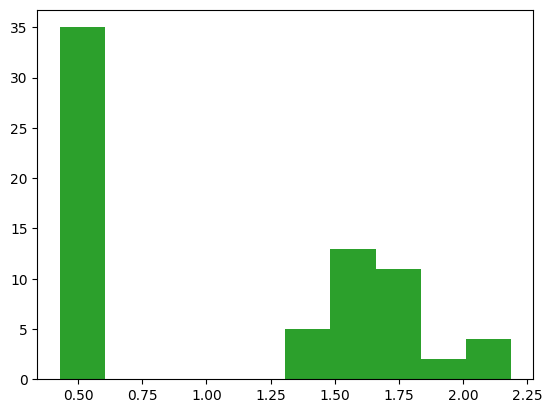

In [27]:
plt.hist(dataset.sel(lat=slice(37.8,37.5), lon=slice(-74, -73.8)).chlor_a.isel(date=0).values.flatten())
plt.hist(dataset.sel(lat=slice(37.8,37.5), lon=slice(-74, -73.8)).chlor_a.isel(date=1).values.flatten())
plt.hist(dataset.sel(lat=slice(37.8,37.5), lon=slice(-74, -73.8)).chlor_a.values.flatten())
#plt.hist(val.chlor_a.values.flatten)
#plt.show()

## 6. Download Data

Let's go ahead and download a couple granules.

Let's look at the `earthaccess.download` function, which is used
to copy files onto a filesystem local to the machine executing the
code. For this function, provide the output of
`earthaccess.search_data` along with a directory where `earthaccess` will store downloaded granules.

Even if you only want to read a slice of the data, and downloading
seems unncessary, if you use `earthaccess.open` while not running on a remote host with direct access to the NASA Earthdata Cloud,
performance will be very poor. This is not a problem with "the
cloud" or with `earthaccess`, it has to do with the data format and may soon be resolved.


In [38]:
tspan = ("2025-03-01", "2025-05-30")
bbox = (-71.5, 43, -65, 48)
clouds = (0, 60)

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

The `paths` list now contains paths to actual files on the local
filesystem.

In [39]:
paths = earthaccess.download(results, local_path="data")
paths

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

We can open up that locally saved file using `xarray` as well.

In [40]:
open_datatree(paths[0])

<xarray.DataTree>
Group: /
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data BGC
│       product_name:                      PACE_OCI.20250319T174816.L2.OC_BGC.V3_...
│       processing_version:                3.0
│       history:                           l2gen par=/data10/sdpsoper/vdc/vpu29/w...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -62.6541
│       geospatial_lon_min:                -95.79886
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     1.0086592435836792
├── Group: /sensor_band_parameters
│       Dimensions:      (number_of_bands: 286, number_of_reflective_bands: 286)
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength   (number_of_bands) float64 2kB ...
│           vcal_gain    (number_of_reflective_bands) float32 1kB ...
│           vcal_offset  (number_of_reflective_bands) float32 1kB ...
│           F0           (number_of_reflective_bands) float32 1kB ...
│           aw           (number_of_reflective_bands) float32 1kB ...
│           bbw          (number_of_reflective_bands) float32 1kB ...
│           k_oz         (number_of_reflective_bands) float32 1kB ...
│           k_no2        (number_of_reflective_bands) float32 1kB ...
│           Tau_r        (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables: (12/13)
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           time     (number_of_lines) datetime64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           ...       ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:           (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           chlor_a           (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
│           poc               (number_of_lines, pixels_per_line) float32 9MB ...
│           chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [-88.45814 -62.6541  -64.36122 -95.79886]
│           gringpointlatitude:   [20.602541 25.86642  43.69763  37.893944]
│           gringpointsequence:   [1 2 3 4]
└── Group: /processing_control
    │   Attributes:
    │       software_name:     l2gen
    │       software_version:  9.11.0-V2025.1
    │       input_sources:     PACE_OCI.2025031

[back to top](#Contents)

# Now let's look at some spectra

In [41]:
tspan = ("2025-03-01", "2025-05-30")
bbox = (-71.5, 43, -65, 48)
clouds = (0, 60)


results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

In [42]:
datatree = open_datatree(paths[2])
datatree

dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))
dataset

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1709,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB ...
    angstrom       (number_of_lines, pixels_per_line) float32 9MB ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250322T175622.L2.OC_AOP.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data5/sdpsoper/vdc/vpu24/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -64.75143
    geospatial_lon_min:                -98.426315
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0069518089294434

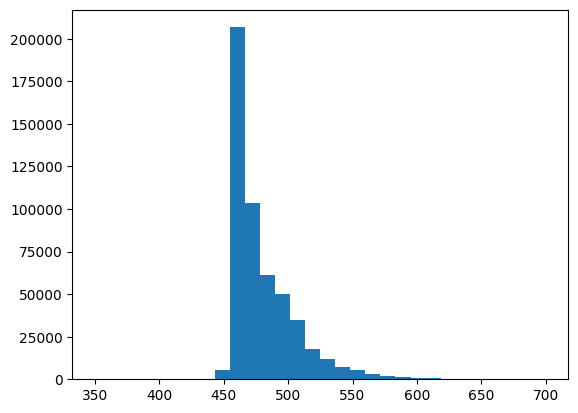

In [43]:
plt.hist(dataset["avw"].values.flatten(), range=[350,700], bins=30)
plt.show()

NameError: name 'dataset' is not defined

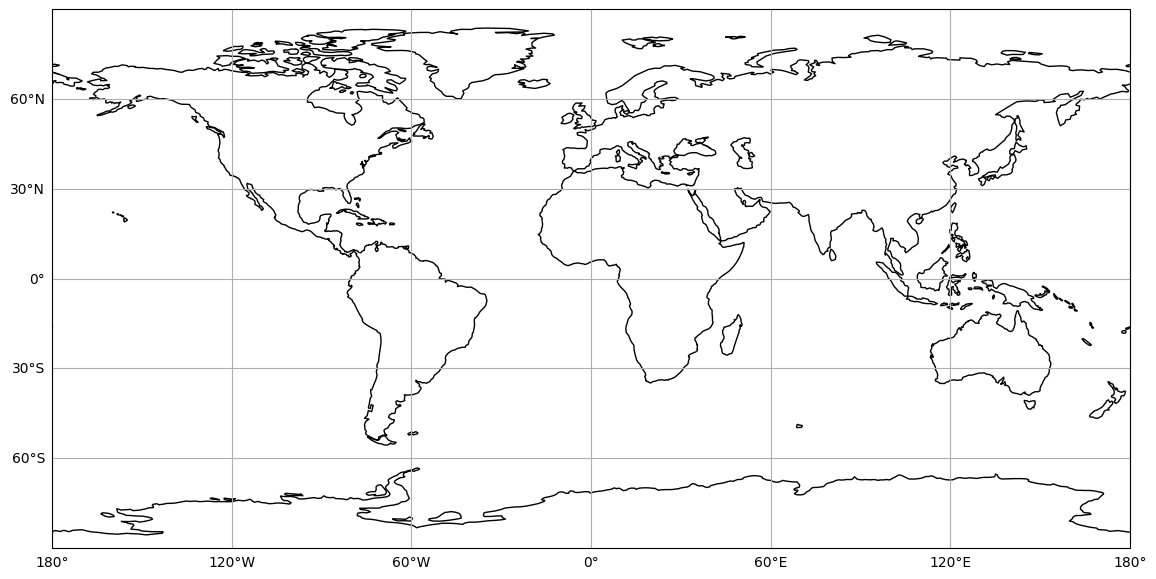

In [5]:
fig = plt.figure(figsize=(18,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["avw"].plot(x="longitude", y="latitude", cmap=cmocean.cm.haline, ax=ax, norm=LogNorm(vmin=430, vmax=550))

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)

# plt.savefig('figs/cocco_chla.png',dpi=300,transparent=True)

Now we often want to grab a specific pixel and inspect the spectra and other attributes

In [ ]:
# I want to find the speed at a certain lat/lon point.
lat = 37
lon = -74

# First, find the index of the grid point nearest a specific lat/lon.
abslat = np.abs(dataset.latitude-lat)
abslon = np.abs(dataset.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

In [ ]:
# Now I can use that index location to get the values at the x/y diminsion
point_ds = dataset.sel(pixels_per_line=xloc, number_of_lines=yloc)

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(point_ds.wavelength_3d,point_ds["Rrs"].values.reshape(-1,172).T)
plt.axhline(0,ls='--')

plt.show()

Or we can mask out a specific section for analysis

In [45]:
min_lon = -75
min_lat = 36
max_lon = -72
max_lat = 37

mask_lon = (dataset.longitude >= min_lon) & (dataset.longitude <= max_lon)
mask_lat = (dataset.latitude >= min_lat) & (dataset.latitude <= max_lat)
dataset = dataset.where(mask_lon & mask_lat,drop=True)

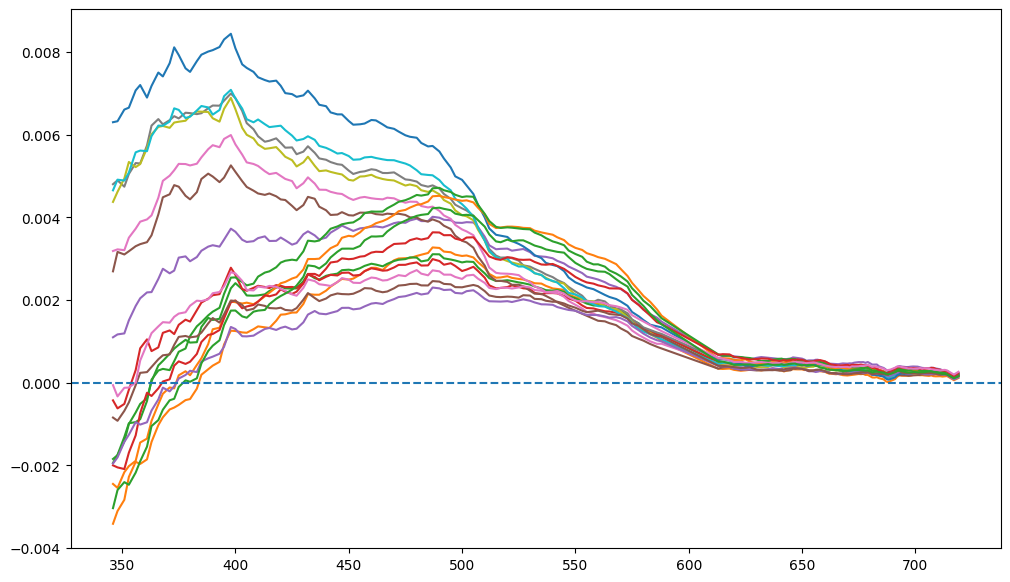

In [46]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(dataset.wavelength_3d,dataset["Rrs"].values.reshape(-1,172)[::500].T)
plt.axhline(0,ls='--')

plt.show()

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["avw"].plot(x="longitude", y="latitude", cmap=cmocean.cm.haline, ax=ax, vmin=430, vmax=550)

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)